# Alpha-Beta seperately

Our previous model trained on the entire dataset (with both alpha and beta). Now we will train two models, one for alpha and one for beta. This will give us two prediction, which we will then average to get the final prediction.

In [40]:
# andere baseline? Beta en alpha keten nu. Als baseline: 2 modellen: eentje voor beta, eentje voor alfa. Beta trainen op alpha keten, alfa
# baseline beter werken dan clf met enkel alfa of beta? of model trainen op

# nieuwe preprint: nieuwe benchmark dataset. Pieter zet op Slack.

In [41]:
from util import get_train_dataset, get_features, fix_test, plot_roc_curve
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split

df = get_train_dataset()
# df = df.sample(n=1000) # for faster debugging
train, test = train_test_split(df, test_size=0.2, random_state=42)

x = get_features(train)  # contains both alfa and beta features
y = train['reaction']

# Keep only the columns starting with 'alpha_'
x_alpha = x[x.columns[x.columns.str.startswith('alfa_')]]
x_beta = x[x.columns[x.columns.str.startswith('beta_')]]

x_test = get_features(test, test=True) # Note: Without the test=True, I'm still getting the almost perfect prediciton error
x_test  = fix_test(x_test, x.columns)
y_test = test['reaction']

x_test_alpha = x_test[x_test.columns[x_test.columns.str.startswith('alfa_')]]
x_test_beta = x_test[x_test.columns[x_test.columns.str.startswith('beta_')]]

C:\Users\arnod\PycharmProjects\thesis\util\classification.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  x_test[col] = np.nan  # TODO: NaN geven


Try a random forest classifier

In [42]:
from sklearn.ensemble import RandomForestClassifier

# Random forest doesn't support NaN values
x_alpha = x_alpha.fillna(0)
x_beta = x_beta.fillna(0)
x_test_alpha = x_test_alpha.fillna(0)
x_test_beta = x_test_beta.fillna(0)

clf_alpha = RandomForestClassifier(n_estimators=200, random_state=42)
clf_beta = RandomForestClassifier(n_estimators=200, random_state=42)

In [43]:
clf_alpha.fit(x_alpha, y)
clf_beta.fit(x_beta, y)

RandomForestClassifier(n_estimators=200, random_state=42)

In [44]:
y_pred_alpha = clf_alpha.predict_proba(x_test_alpha)[:, 1]
y_pred_beta = clf_beta.predict_proba(x_test_beta)[:, 1]

In [45]:
from sklearn import metrics

def calculate_auc_and_plot(y_test, y_pred):

    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred, pos_label=1)
    roc_auc = metrics.auc(fpr, tpr)

    plot_roc_curve(fpr, tpr, label=f'ROC curve (area = {roc_auc:.3f})', title='ROC curve')

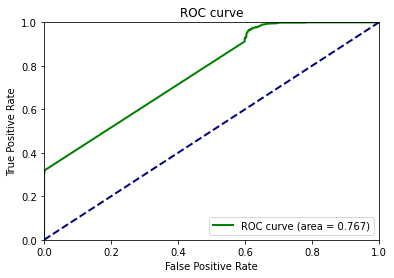

In [46]:
# Calculate AUC for alpha
calculate_auc_and_plot(y_test, y_pred_alpha) # TODO: kijken of veel alpha's zelfde score?

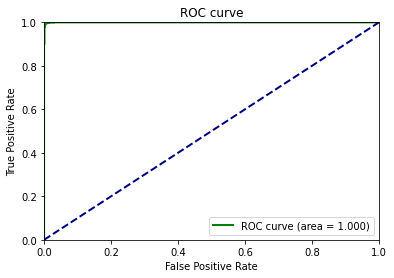

In [47]:
# Calculate AUC for beta
calculate_auc_and_plot(y_test, y_pred_beta)

In [48]:
y_pred = (y_pred_alpha + y_pred_beta) / 2

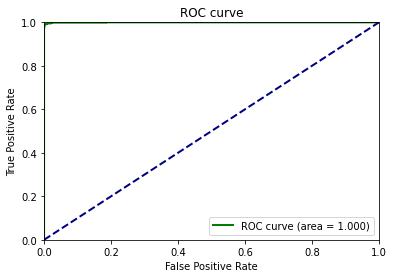

In [49]:
calculate_auc_and_plot(y_test, y_pred)

In [50]:
# y_pred is predicted using predict_proba, so we need to convert it to 0/1
y_pred_label = (y_pred > 0.5).astype(int)
print(metrics.classification_report(y_test, y_pred_label))
print(metrics.confusion_matrix(y_test, y_pred_label))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       841
           1       1.00      0.98      0.99       821

    accuracy                           0.99      1662
   macro avg       0.99      0.99      0.99      1662
weighted avg       0.99      0.99      0.99      1662

[[840   1]
 [ 14 807]]


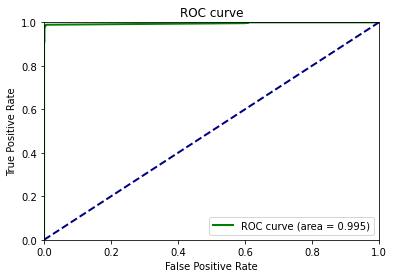

In [51]:
# Instead of averaging the predictions, we can also take the maximum or minimum
import numpy as np
y_pred_max = np.maximum(y_pred_alpha, y_pred_beta)

calculate_auc_and_plot(y_test, y_pred_max)


In [52]:
y_pred_max_label = (y_pred_max > 0.5).astype(int)
print(metrics.classification_report(y_test, y_pred_max_label))
print(metrics.confusion_matrix(y_test, y_pred_max_label))

              precision    recall  f1-score   support

           0       0.99      0.40      0.57       841
           1       0.62      1.00      0.76       821

    accuracy                           0.69      1662
   macro avg       0.80      0.70      0.67      1662
weighted avg       0.81      0.69      0.66      1662

[[335 506]
 [  3 818]]


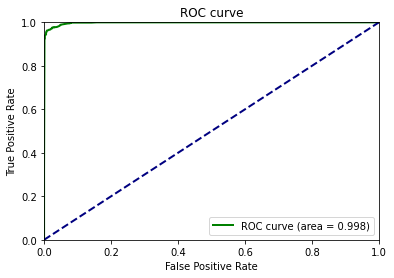

In [53]:
# Or the minimum
y_pred_min = np.minimum(y_pred_alpha, y_pred_beta)

calculate_auc_and_plot(y_test, y_pred_min)

In [54]:
y_pred_min_label = (y_pred_min > 0.5).astype(int)
print(metrics.classification_report(y_test, y_pred_min_label))
print(metrics.confusion_matrix(y_test, y_pred_min_label))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96       841
           1       1.00      0.90      0.95       821

    accuracy                           0.95      1662
   macro avg       0.96      0.95      0.95      1662
weighted avg       0.96      0.95      0.95      1662

[[840   1]
 [ 78 743]]


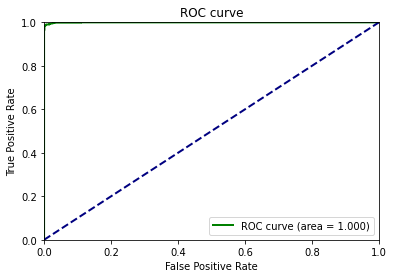

In [55]:
# Or the product
y_pred_product = y_pred_alpha * y_pred_beta

calculate_auc_and_plot(y_test, y_pred_product)

In [56]:
y_pred_product_label = (y_pred_product > 0.5).astype(int)
print(metrics.classification_report(y_test, y_pred_product_label))
print(metrics.confusion_matrix(y_test, y_pred_product_label))

              precision    recall  f1-score   support

           0       0.65      1.00      0.79       841
           1       1.00      0.45      0.62       821

    accuracy                           0.73      1662
   macro avg       0.82      0.72      0.70      1662
weighted avg       0.82      0.73      0.70      1662

[[841   0]
 [454 367]]


Product and average seem to perform the best, yielding a similar result as the model trained on the entire dataset. (and better than the model trained on only alpha or beta).

# Complete only
I'm interested now in how the missing values affects those predictions. Let's see what happens if we remove the rows with missing values.

In [70]:
from util import get_train_dataset, get_features, fix_test, plot_roc_curve
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split

df = get_train_dataset()
# df = df.sample(n=1000) # for faster debugging

df_length = len(df)
df = df.dropna() # Must be here and not after the get_features, since get_features might also introduce NaN values
print(f'Number of rows removed: {df_length - len(df)} ({(df_length - len(df)) / df_length * 100:.2f}%)')

train, test = train_test_split(df, test_size=0.2, random_state=42)

x = get_features(train)  # contains both alfa and beta features
y = train['reaction']

# Keep only the columns starting with 'alpha_'
x_alpha = x[x.columns[x.columns.str.startswith('alfa_')]]
x_beta = x[x.columns[x.columns.str.startswith('beta_')]]

x_test = get_features(test, test=True) # Note: Without the test=True, I'm still getting the almost perfect prediciton error
x_test  = fix_test(x_test, x.columns)
y_test = test['reaction']

x_test_alpha = x_test[x_test.columns[x_test.columns.str.startswith('alfa_')]]
x_test_beta = x_test[x_test.columns[x_test.columns.str.startswith('beta_')]]

# dit model hierboven ook test op zelfde testset
# is dat omdat model beter is of omdat testset makkelijker te voorspellen?
# literatuur induiken, algemeen missing data

Number of rows removed: 4841 (58.28%)


In [71]:
# Remove NaN's introduced by get_features
x_alpha = x_alpha.fillna(0)
x_beta = x_beta.fillna(0)
x_test_alpha = x_test_alpha.fillna(0)
x_test_beta = x_test_beta.fillna(0)

In [72]:
from sklearn.ensemble import RandomForestClassifier

clf_alpha = RandomForestClassifier(n_estimators=200, random_state=42)
clf_beta = RandomForestClassifier(n_estimators=200, random_state=42)

In [73]:
clf_alpha.fit(x_alpha, y)
clf_beta.fit(x_beta, y)

RandomForestClassifier(n_estimators=200, random_state=42)

In [74]:
y_pred_alpha = clf_alpha.predict_proba(x_test_alpha)[:, 1]
y_pred_beta = clf_beta.predict_proba(x_test_beta)[:, 1]

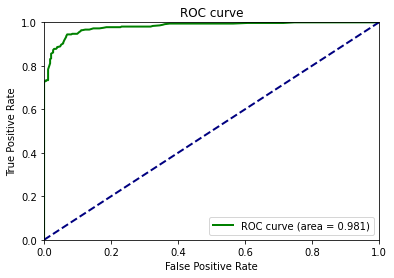

0.980601099714673

In [75]:
calculate_auc_and_plot(y_test, y_pred_alpha)

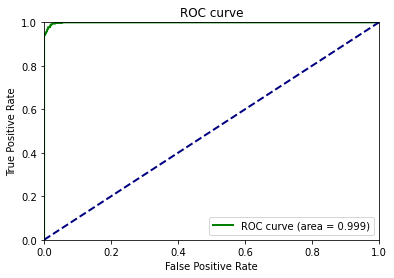

0.9991307096570254

In [76]:
calculate_auc_and_plot(y_test, y_pred_beta)

In [77]:
y_pred = (y_pred_alpha + y_pred_beta) / 2

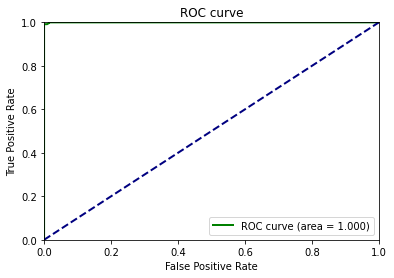

In [65]:
calculate_auc_and_plot(y_test, y_pred)

In [66]:
y_pred_label = (y_pred > 0.5).astype(int)
print(metrics.classification_report(y_test, y_pred_label))
print(metrics.confusion_matrix(y_test, y_pred_label))

              precision    recall  f1-score   support

           0       0.94      1.00      0.97       333
           1       1.00      0.94      0.97       361

    accuracy                           0.97       694
   macro avg       0.97      0.97      0.97       694
weighted avg       0.97      0.97      0.97       694

[[333   0]
 [ 22 339]]


Alpha tells us more than beta here.

In [67]:
# Let's also create one model using both alpha and beta features
from util import get_train_dataset, get_features, fix_test, plot_roc_curve # calculate_auc_and_plot
from sklearn.model_selection import train_test_split


df = get_train_dataset()
# df = df.sample(n=1000) # for faster debugging
df = df.dropna()

train, test = train_test_split(df, test_size=0.2, random_state=42)

x = get_features(train)  # contains both alfa and beta features
y = train['reaction']

x_test = get_features(test, test=True)
x_test  = fix_test(x_test, x.columns)
y_test = test['reaction']

# Remove NaN's introduced by get_features
x = x.fillna(0)
x_test = x_test.fillna(0)

In [68]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=200, random_state=42)
clf.fit(x, y)

RandomForestClassifier(n_estimators=200, random_state=42)

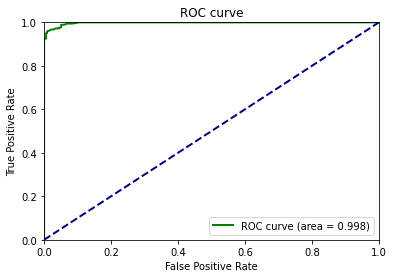

0.9977664645254674

In [69]:
from util import calculate_auc_and_plot
y_pred = clf.predict_proba(x_test)[:, 1]
calculate_auc_and_plot(y_test, y_pred)

# Summary
## Seperate models
I tried generating a seperate model for the alpha part and a seperate model for the beta part. Both models used a random forest classifier (since this has been one of the best models for this) and the NaN's where filled with 0. I didn't drop any rows, so the alpha model contained a lot of rows containing only zeros.

The alpha model was trained on all alpha columns, the beta model on all beta columns. Those classifiers give a probability as output. The ROC curve of the alpha model contained a straight line, which is probably because of all 0 rows. Alpha model had an AUC of 0.767, the beta model 0.794.

I tried different ways of combining the results of those models. Taking the average resulted in an ROC of 0.876 (which is the same as when using one random forest model on all columns). The misclassifications where mainly false positivess. Product gave similar results. Maximum and minimum slightly worse.

## Complete only
I was also interested in the accuracy if I dropped all rows conaining NaN's (58% of the rows). I created a seperate model for the alpha columns and a seperate model for the beta columns. This resulted in an AUC of 0.981 for the alpha model, 0.887 for the beta model. The combination (avg) had an AUC of 0.983, which is slightly higher than one model trained on both alpha and beta together (0.968).

Model met op nan's getraind, zien hoe dat werkt op de testsetmet nan's (wel meer data om op te trainen), vooral vraag is er een meerwaarde om nan's mee te rekenen om modellen beter te maken'

# NaN's in train, not in test
A seperate test to see whether the NaN's actually improved the model (even if the test set doesn't contain any NaN's).

In [24]:
from util import get_train_dataset, get_features, fix_test, plot_roc_curve
from sklearn.model_selection import train_test_split

df = get_train_dataset()
# df = df.sample(n=1000) # for faster debugging

In [25]:
train, test = train_test_split(df, test_size=0.2, random_state=42)

In [26]:
df_test_length = len(test)
test = test.dropna()
print(f'Number of rows removed: {df_test_length - len(test)} ({(df_test_length - len(test)) / df_test_length * 100:.2f}%)')

Number of rows removed: 991 (59.63%)


In [27]:
x = get_features(train)
y = train['reaction']

## Alpha and beta together

In [28]:
x_test = get_features(test, test=True) # Note: Without the test=True, I'm still getting the almost perfect prediciton error
x_test  = fix_test(x_test, x.columns)
y_test = test['reaction']

C:\Users\arnod\PycharmProjects\thesis\util\classification.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  x_test[col] = np.nan  # TODO: NaN geven


In [29]:
x = x.fillna(0)
x_test = x_test.fillna(0)

In [30]:
clf = RandomForestClassifier(random_state=42)
clf.fit(x, y)

RandomForestClassifier(random_state=42)

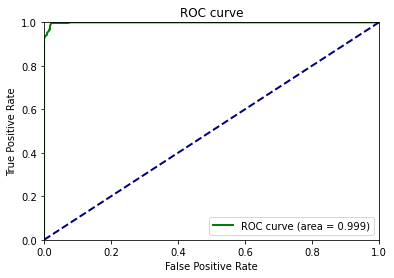

0.9988850192789495

In [31]:
y_pred = clf.predict_proba(x_test)[:, 1]
calculate_auc_and_plot(y_test, y_pred)

## Alpha and beta seperately

In [32]:
# Keep only the columns starting with 'alpha_'
x_alpha = x[x.columns[x.columns.str.startswith('alfa_')]]
x_beta = x[x.columns[x.columns.str.startswith('beta_')]]

In [33]:
x_test_alpha = x_test[x_test.columns[x_test.columns.str.startswith('alfa_')]]
x_test_beta = x_test[x_test.columns[x_test.columns.str.startswith('beta_')]]

In [34]:
x_alpha = x_alpha.fillna(0)
x_beta = x_beta.fillna(0)
x_test_alpha = x_test_alpha.fillna(0)
x_test_beta = x_test_beta.fillna(0)

In [35]:
from sklearn.ensemble import RandomForestClassifier

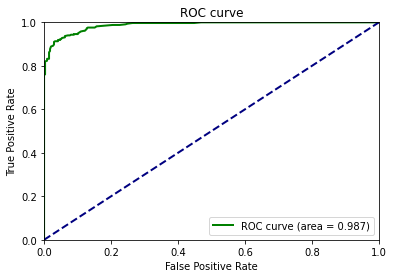

0.9870688889283749

In [36]:
clf_alpha = RandomForestClassifier(n_estimators=200, random_state=42)
clf_alpha.fit(x_alpha, y)
y_pred_alpha = clf_alpha.predict_proba(x_test_alpha)[:, 1]
calculate_auc_and_plot(y_test, y_pred_alpha)

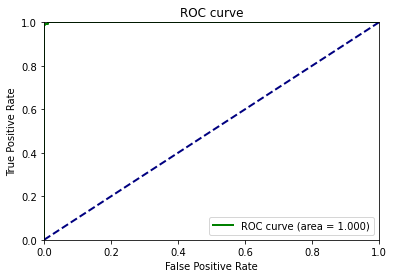

0.9999111569146573

In [37]:
clf_beta = RandomForestClassifier(n_estimators=200, random_state=42)
clf_beta.fit(x_beta, y)
y_pred_beta = clf_beta.predict_proba(x_test_beta)[:, 1]
calculate_auc_and_plot(y_test, y_pred_beta)

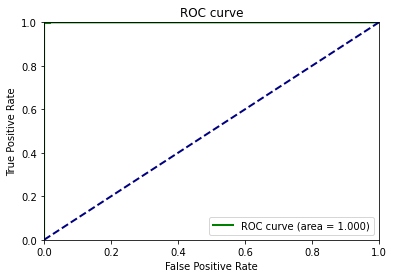

0.9999422519945274

In [38]:
y_pred = (y_pred_alpha + y_pred_beta) / 2
calculate_auc_and_plot(y_test, y_pred)

In [39]:
from sklearn import metrics
y_pred_label = (y_pred > 0.5).astype(int)
print(metrics.classification_report(y_test, y_pred_label))
print(metrics.confusion_matrix(y_test, y_pred_label))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       337
           1       1.00      0.98      0.99       334

    accuracy                           0.99       671
   macro avg       0.99      0.99      0.99       671
weighted avg       0.99      0.99      0.99       671

[[337   0]
 [  8 326]]
